### Value Iteration

In [1]:
import gym,time
from gym import envs
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import mediapy as media
from moviepy.video.io.bindings import mplfig_to_npimage
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
np.set_printoptions(precision=2)
plt.rc('xtick',labelsize=8); plt.rc('ytick',labelsize=8)
print ("gym:[%s]"%(gym.__version__))
print ("numpy:[%s]"%(np.__version__))
print ("matplotlib:[%s]"%(matplotlib.__version__))

gym:[0.26.2]
numpy:[1.22.4]
matplotlib:[3.7.1]


Helper Function

In [2]:
def plot_env(env,figsize=(4,4),title_str=None,title_fs=10,
             PLOT_IMG=True,RETURN_IMG=False):
    img = env.render()
    fig = plt.figure(figsize=figsize)
    plt.imshow(img)
    plt.axis('off')
    if title_str is not None:
        plt.title(title_str,fontsize=title_fs)
    if PLOT_IMG:
        plt.show()
    # (Optional) Get image
    if RETURN_IMG:
        img = mplfig_to_npimage(fig)
        plt.close()
        return img
    
def visualize_matrix(M,strs='',figsize=(4,4),fontsize=15,
                     cmap='turbo',title='Title',title_fs=15,REMOVE_TICK_LABELS=True,
                     PLOT_IMG=True,RETURN_IMG=False):
    """
    Visualize a matrix colors and strings 
    """
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    n_row,n_col = M.shape[0],M.shape[1]
    
    fig,ax = plt.subplots(figsize=figsize)
    divider = make_axes_locatable(ax)
    im = ax.imshow(M,cmap=plt.get_cmap(cmap),extent=(0,n_col,n_row,0),
              interpolation='nearest',aspect='equal')
    ax.set_xticks(np.arange(0,n_col,1))
    ax.set_yticks(np.arange(0,n_row,1))
    ax.grid(color='w', linewidth=2)
    ax.set_frame_on(False)
    x,y = np.meshgrid(np.arange(0,n_col,1.0),np.arange(0,n_row,1.0))
    if len(strs) == n_row*n_col:
        idx = 0
        for x_val,y_val in zip(x.flatten(), y.flatten()):
            c = strs[idx]
            idx = idx + 1
            ax.text(x_val+0.5,y_val+0.5,c,va='center', ha='center',size=fontsize)
    cax = divider.append_axes('right', size='5%', pad=0.05)            
    fig.colorbar(im, cax=cax, orientation='vertical')
    fig.suptitle(title,size=title_fs) 
    fig.tight_layout()
    fig.subplots_adjust(top=1.05)
    if REMOVE_TICK_LABELS:
        plt.setp(ax.get_xticklabels(),visible=False)
        plt.setp(ax.get_yticklabels(),visible=False)
    if PLOT_IMG:
        plt.show()
    if RETURN_IMG:
        img = mplfig_to_npimage(fig)
        plt.close()
        return img
print ("Ready.")

Ready.


### Initialize Environment

In [3]:
env = gym.make('FrozenLake8x8-v1',render_mode='rgb_array')
env.reset()
print ("[%s] initialized."%(env.unwrapped.spec.id))

[FrozenLake8x8-v1] initialized.


In [4]:
obs_space = env.observation_space
n_state = obs_space.n
action_space = env.action_space
n_action = action_space.n
print("State space:[%d]"%(n_state))
print("Action space:[%d]"%(n_action))

State space:[64]
Action space:[4]


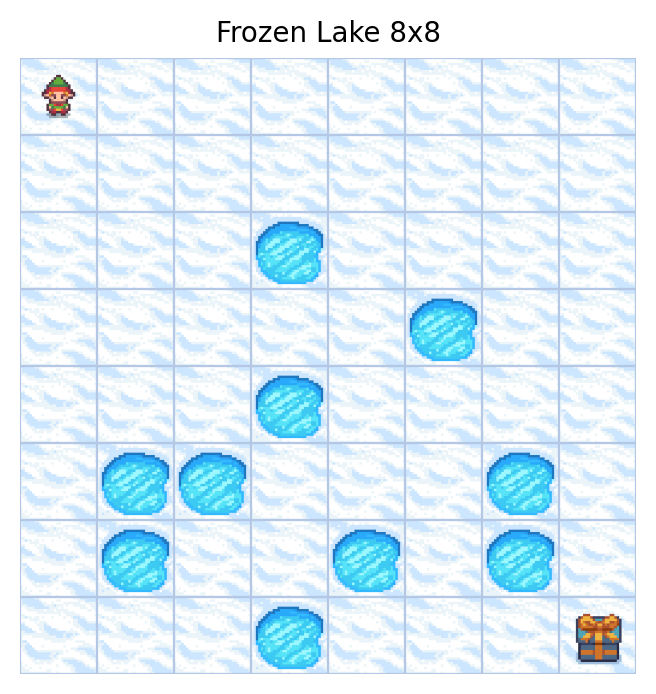

In [5]:
plot_env(env,figsize=(4,4),title_str='Frozen Lake 8x8',title_fs=10)

Plot environment with semantic information

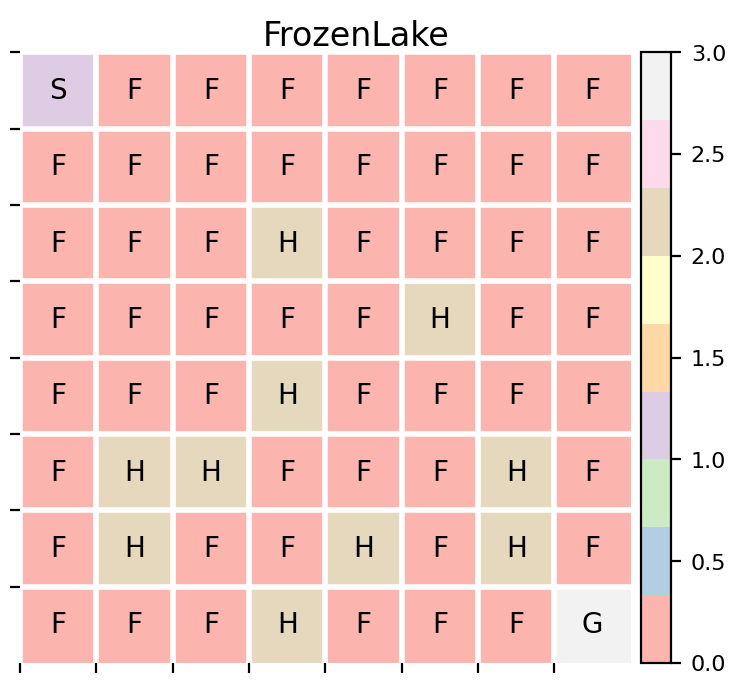

In [6]:
M = np.zeros(shape=(8,8))
strs = ['S','F','F','F','F','F','F','F',
       'F','F','F','F','F','F','F','F',
       'F','F','F','H','F','F','F','F',
       'F','F','F','F','F','H','F','F',
       'F','F','F','H','F','F','F','F',
       'F','H','H','F','F','F','H','F',
       'F','H','F','F','H','F','H','F',
       'F','F','F','H','F','F','F','G']
M[0,0] = 1 # Start
M[2,3]=M[3,5]=M[4,3]=M[5,1]=M[5,2]=M[5,6]=M[6,1]=M[6,4]=M[6,6]=M[7,3]=2 # Hole
M[7,7] = 3 # Goal
visualize_matrix(M,figsize=(4,4),fontsize=10,title_fs=12,
                 strs=strs,cmap='Pastel1',title='FrozenLake',
                 PLOT_IMG=True,RETURN_IMG=False)

### Value iteration
$
V_{k+1}(s) = \max_a \sum_{s'}
\left[
r(s,a,s') + \gamma V_k(s')
\right]
P(s'|s,a)
$

or

$
Q_k(s,a) = \sum_{s'}
\left[
r(s,a,s') + \gamma V_k(s')
\right]
P(s'|s,a)
$
and
$
V_{k+1}(s) = \max_{a'} Q_k(s,a')
$

In [7]:
def value_iteration(env,gamma=0.99,eps=1e-6):
    # Extract the world information
    n_state = env.observation_space.n
    n_action = env.action_space.n
    # Transition probability
    P = env.unwrapped.P
    # Initialize value
    V = np.random.uniform(size=(n_state,1)) # [n_state x 1]
    # Loop 
    tick,V_dists,V_list,Q_list = 0,[],[],[]
    while True:
        tick = tick + 1
        Q = np.zeros(shape=(n_state,n_action)) # [n_state x n_action]
        for s in P.keys(): # for all states s
            for a in P[s].keys(): # for all actions a
                for prob, s_prime, reward, done in P[s][a]:
                    Q[s,a] += (reward + gamma*V[s_prime])*prob
        V_prime = np.max(Q,axis=1) # [n_state x 1]
        V_dist = np.max(np.abs(V-V_prime))
        V_dists.append(V_dist)
        V = V_prime # update
        V_list.append(V)
        Q_list.append(Q)
        if V_dist < eps:
            break
    return Q,V,V_dists,V_list,Q_list

def plot_pi_v(Pi,V,figsize=(4,4),title='Value Function',cmap='turbo',title_fs=15,
              subplots_top=1.0,REMOVE_TICK_LABELS=True,
              PLOT_IMG=True,RETURN_IMG=False):
    """
    Visualize pi and V
    """
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    n_row,n_col = V.shape[0],V.shape[1]
    fig,ax = plt.subplots(figsize=figsize)
    divider = make_axes_locatable(ax)
    im = ax.imshow(V,cmap=plt.get_cmap(cmap),extent=(0,n_col,n_row,0))
    ax.set_xticks(np.arange(0,n_col,1))
    ax.set_yticks(np.arange(0,n_row,1))
    ax.grid(color='w', linewidth=2)
    arr_len = 0.2
    for i in range(8):
        for j in range(8):
            s = i*8+j
            if Pi[s][0]> 0: plt.arrow(j+0.5,i+0.5,-arr_len,0,
                          color="r",alpha=Pi[s][0],width=0.01,
                          head_width=0.5,head_length=0.2,overhang=1)
            if Pi[s][1]> 0: plt.arrow(j+0.5,i+0.5,0,arr_len,
                          color="r",alpha=Pi[s][1],width=0.01,
                          head_width=0.5,head_length=0.2,overhang=1)
            if Pi[s][2]> 0: plt.arrow(j+0.5,i+0.5,arr_len,0,
                          color="r",alpha=Pi[s][2],width=0.01,
                          head_width=0.5,head_length=0.2,overhang=1)
            if Pi[s][3]> 0: plt.arrow(j+0.5,i+0.5,0,-arr_len,
                          color="r",alpha=Pi[s][3],width=0.01,
                          head_width=0.5,head_length=0.2,overhang=1)
    cax = divider.append_axes('right', size='5%', pad=0.05)            
    fig.colorbar(im, cax=cax, orientation='vertical')
    fig.suptitle(title,size=title_fs) 
    fig.tight_layout()
    fig.subplots_adjust(top=subplots_top)
    if REMOVE_TICK_LABELS:
        plt.setp(ax.get_xticklabels(),visible=False)
        plt.setp(ax.get_yticklabels(),visible=False)    
    if PLOT_IMG:
        plt.show()
    if RETURN_IMG:
        img = mplfig_to_npimage(fig)
        plt.close()
        return img
    
print ("Done.")

Done.


### Run Value Iteration

In [8]:
start = time.time()
Q,V,V_dists,V_list,Q_list = value_iteration(env,gamma=0.99,eps=1e-6)
print("It took [%.2f]s."%(time.time()-start))
print ("Value Iteraction converged in [%d] loops."%(len(V_dists)))

It took [0.19]s.
Value Iteraction converged in [895] loops.


Compute the optimal policy and plot 

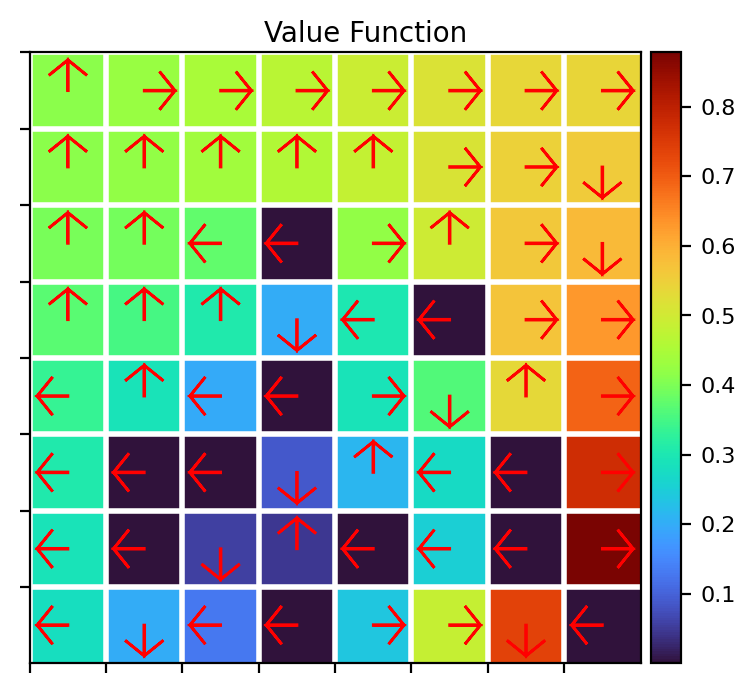

In [9]:
Pi = np.zeros((n_state,n_action))
Pi[np.arange(n_state),np.argmax(Q,axis=1)] = 1
plot_pi_v(Pi=Pi,V=np.reshape(V,(8,8)),figsize=(4,4),title_fs=10,subplots_top=1.05)

Plot the convergence of value iteration

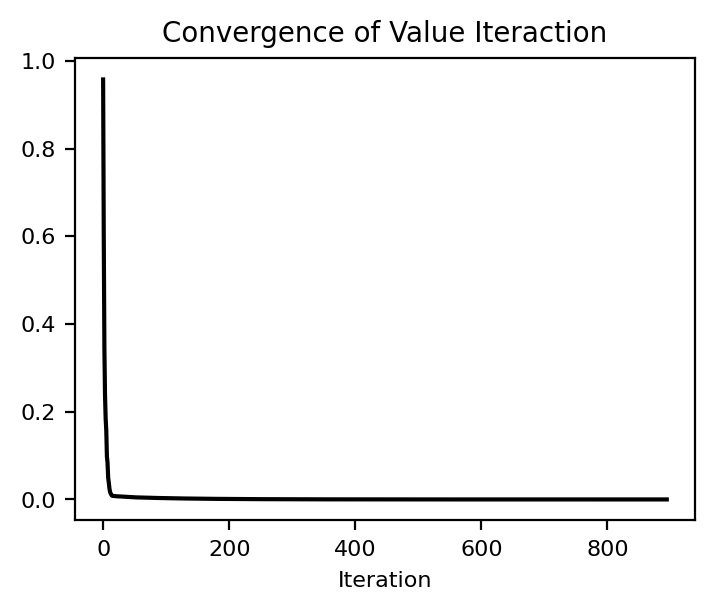

In [10]:
plt.figure(figsize=(4,3))
plt.plot(V_dists,'k-')
plt.xlabel('Iteration',fontsize=8)
plt.title("Convergence of Value Iteraction",fontsize=10)
plt.show()

Animate how the value function changes over iteration

In [11]:
n_plot = 50
frames = []
for itr in np.round(np.linspace(0,len(Q_list)-1,n_plot)).astype(np.int32):
    V,Q = V_list[itr],Q_list[itr]
    Pi = np.zeros((n_state,n_action))
    Pi[np.arange(n_state),np.argmax(Q,axis=1)] = 1
    img = plot_pi_v(
        Pi,np.reshape(V,(8,8)),title="Value Function@iter=%d"%(itr),title_fs=10,
        PLOT_IMG=False,RETURN_IMG=True)
    frames.append(img)
media.show_video(frames, fps=5)
print ("Done.")

Done.


Plot the value functions with different discount factors

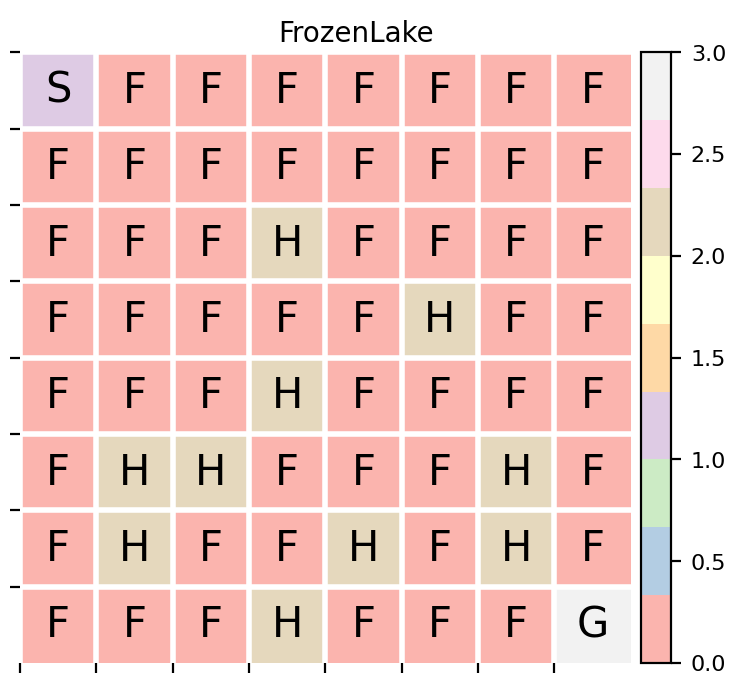

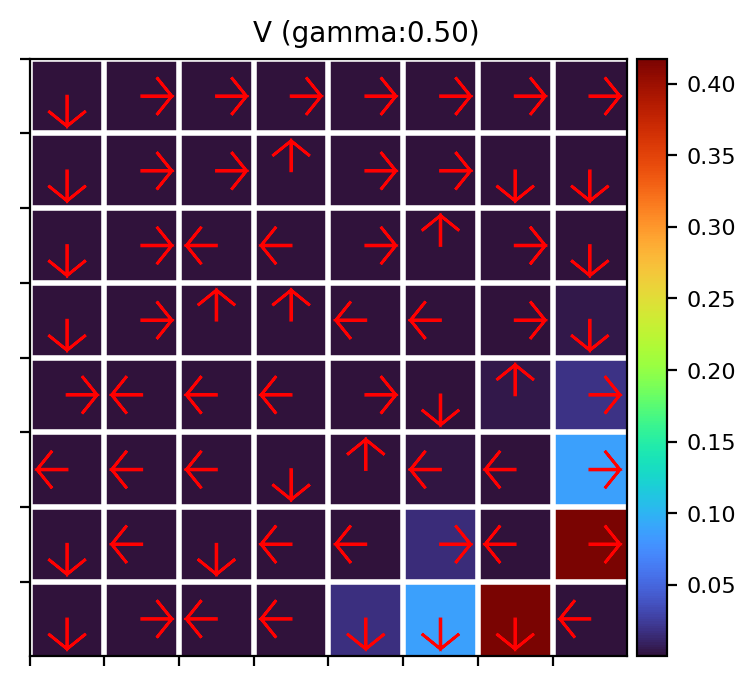

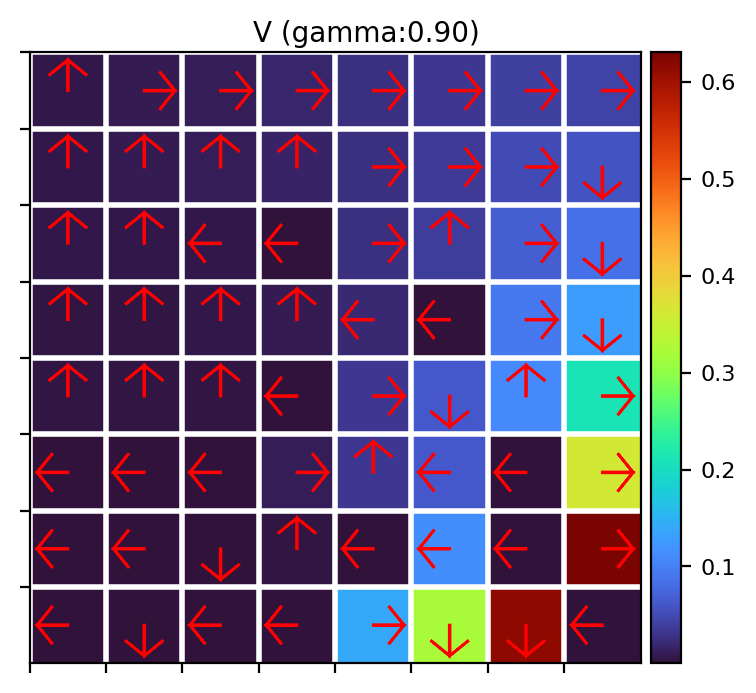

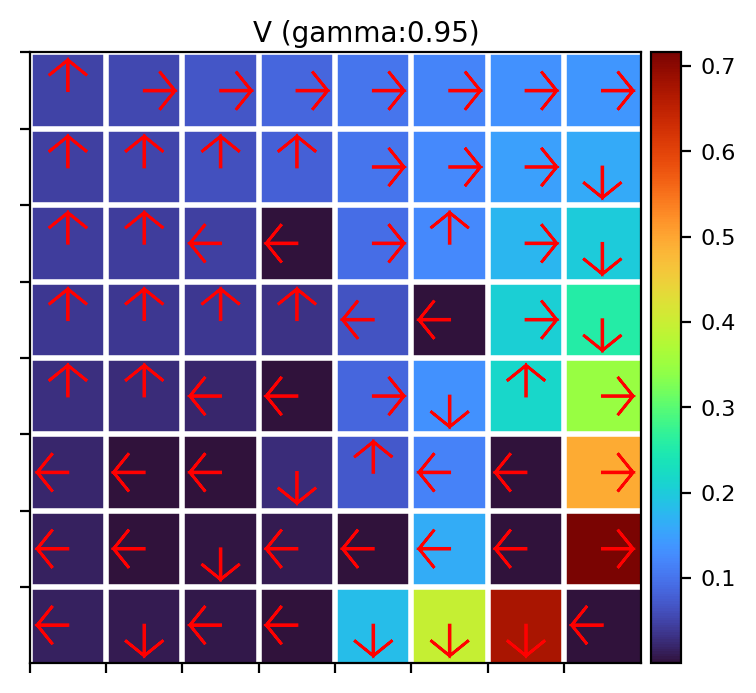

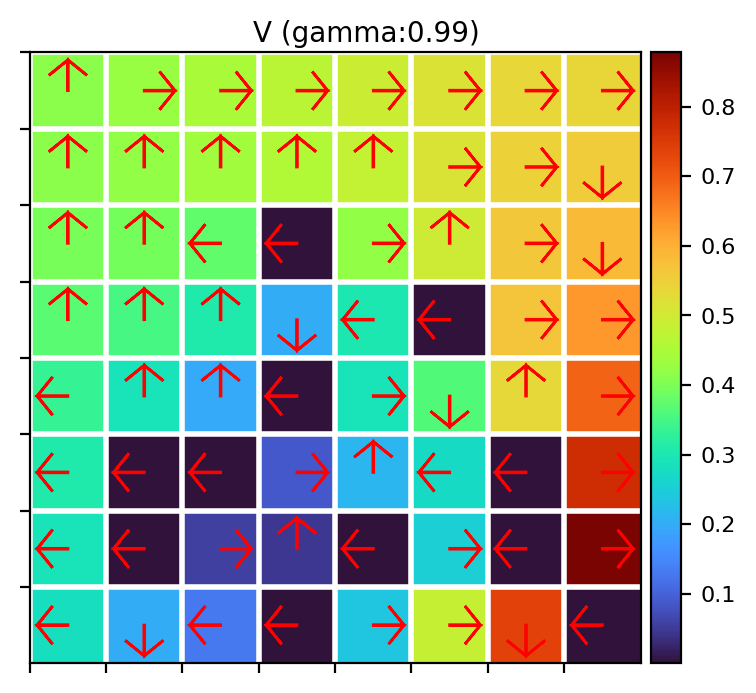

In [12]:
# Run value iteration
visualize_matrix(M,strs=strs,cmap='Pastel1',title='FrozenLake',title_fs=10)
for gamma in [0.5,0.9,0.95,0.99]:
    Q,V,V_dists,V_list,Q_list = value_iteration(env,gamma=gamma,eps=1e-6)
    Pi = np.zeros((n_state,n_action))
    Pi[np.arange(n_state),np.argmax(Q,axis=1)] = 1
    plot_pi_v(Pi,np.reshape(V,(8,8)),title='V (gamma:%.2f)'%gamma,
              subplots_top=1.05,title_fs=10)

Animate the optimal policy

In [13]:
# Solve value iteration
gamma = 0.99
Q,V,V_dists,V_list,Q_list = value_iteration(env,gamma=gamma,eps=1e-6)
Pi = np.zeros((n_state,n_action))
Pi[np.arange(n_state),np.argmax(Q,axis=1)] = 1
obs,_ = env.reset() # reset env
ret,frames = 0,[]
for tick in range(1000):
    action = np.random.choice(n_action,1,p=Pi[obs][:])[0] # select action
    next_obs,reward,done,truncated,info = env.step(action)
    # Render
    title_str = "tick:[%d] action:[%s] reward:[%.2f] done:[%d]"%(
        tick,action,reward,done
    )
    img = plot_env(env,figsize=(4,4),title_str=title_str,title_fs=8,
                   PLOT_IMG=False,RETURN_IMG=True)
    frames.append(img)
    obs = next_obs
    ret = reward + gamma*ret
    if done: break
env.close()
print ("Return is [%.3f] (tick:[%d])"%(ret,tick))

Return is [1.000] (tick:[55])


In [14]:
media.show_video(frames, fps=5)

Animate random policy

In [15]:
obs,_ = env.reset() # reset env
ret,frames = 0,[]
for tick in range(1000):
    action = env.action_space.sample()
    next_obs,reward,done,truncated,info = env.step(action)
    # Render
    title_str = "tick:[%d] action:[%s] reward:[%.2f] done:[%d]"%(
        tick,action,reward,done
    )
    img = plot_env(env,figsize=(4,4),title_str=title_str,title_fs=8,
                   PLOT_IMG=False,RETURN_IMG=True)
    frames.append(img)
    obs = next_obs
    ret = reward + gamma*ret
    if done: break
env.close()
print ("Return is [%.3f] (tick:[%d])"%(ret,tick))

Return is [0.000] (tick:[9])


In [16]:
media.show_video(frames, fps=5)